In [91]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import tensorflow as tf
import spacy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
# Load the dataset
news_data = pd.read_csv('BBC News Train.csv')  # Replace 'news_dataset.csv' with your dataset file path

# Display the first few rows of the dataset
news_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## Exploratory Data Analysis

In [9]:
# Summary statistics of numerical columns
print(news_data.describe())

         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


In [14]:
# Basic information about the dataset
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [15]:
# Check for missing values
news_data.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

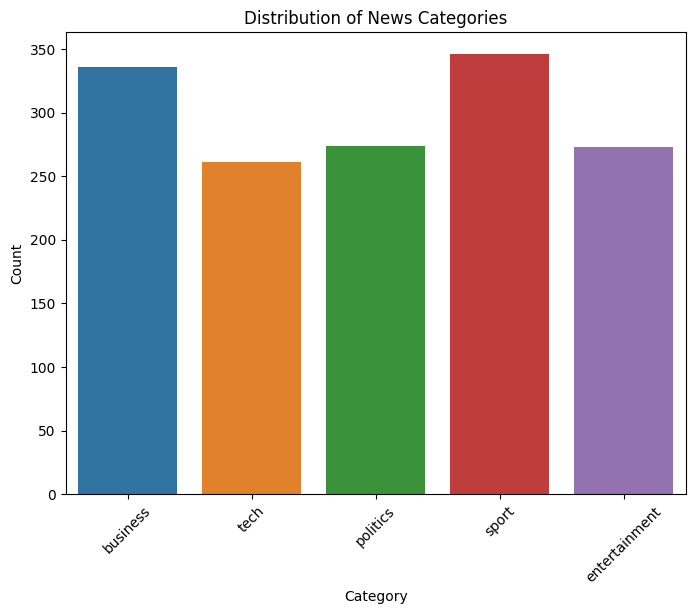

In [12]:
# Data visualization
# Example: Distribution of target classes
plt.figure(figsize=(8, 6))
sns.countplot(x='Category', data=news_data)
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


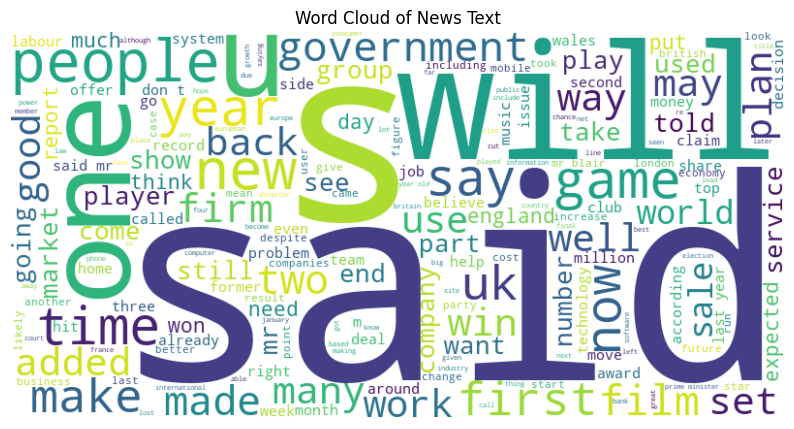

In [13]:
from wordcloud import WordCloud

# Combine all text data into a single string
all_text = ' '.join(news_data['Text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Text')
plt.show()

## Model Implementaion

In [17]:
nlp = spacy.load("en_core_web_sm")
 
# Sample text
text = "There is a pen on the table"
 
# Process the text using spaCy
doc = nlp(text)
 
# Remove stopwords
filtered_words = [token.text for token in doc if not token.is_stop]
 
# Join the filtered words to form a clean text
clean_text = ' '.join(filtered_words)
 
print("Original Text:", text)
print("Text after Stopword Removal:", clean_text)

Original Text: There is a pen on the table
Text after Stopword Removal: pen table


## Defining Some Basic Functions

In [18]:
def remove_stopwords(text):
    doc = nlp(text)
    tokens_without_sw = [token.text for token in doc if not token.is_stop]
    return " ".join(tokens_without_sw)

In [19]:
def parse_data_from_file(filename):
    # lists to include sentences and labels separately
    sentences = []
    labels = []

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skipping the header row

        for row in reader:
            # add the corresponding category of a news article into the 'labels' list
            labels.append(row[2])

            # add the texts of a news article into the 'sentences' list
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [20]:
sentences, labels = parse_data_from_file("BBC News Train.csv")

print(f"Number of sentences in the training dataset: {len(sentences)}\n")
print(f"Number of words in the 1st sentence (after removing stopwords). {len(sentences[0].split())}\n")
print(f"Number of labels in the dataset: {len(labels)}\n")
print(f"First 10 labels: {labels[:10]}")

Number of sentences in the training dataset: 1490

Number of words in the 1st sentence (after removing stopwords). 208

Number of labels in the dataset: 1490

First 10 labels: ['business', 'business', 'business', 'tech', 'business', 'politics', 'sport', 'entertainment', 'business', 'entertainment']


In [21]:
def train_val_split(sentences, labels, training_split):
    train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(
        sentences, labels, train_size=training_split, random_state=42)
 
    return train_sentences, validation_sentences, train_labels, validation_labels


In [22]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, 0.75)

In [23]:
print(f"Number of sentences for training: {len(train_sentences)} \n")
print(f"Number of labels for training: {len(train_labels)}\n")
print(f"Number of sentences for validation: {len(val_sentences)} \n")
print(f"Number of labels for validation: {len(val_labels)}")

Number of sentences for training: 1117 

Number of labels for training: 1117

Number of sentences for validation: 373 

Number of labels for validation: 373


In [24]:
def fit_tokenizer(train_sentences, num_words, oov_token):    
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [25]:
num_words = 1000
oov_token = "<OOV>"

tokenizer = fit_tokenizer(train_sentences, num_words, oov_token)

word_index = tokenizer.word_index

print(f"Number of words in the vocabulary: {len(word_index)}\n")

Number of words in the vocabulary: 21712



In [39]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):       
    sequences = tokenizer.texts_to_sequences(sentences)
    
    padded_sequences = pad_sequences(sequences, 
                                     maxlen=maxlen, 
                                     padding=padding, 
                                     truncating='post')
    
    return padded_sequences

In [40]:
padding = 'post'
max_len = 120

train_padded_seq = seq_and_pad(train_sentences, tokenizer, padding, max_len)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, padding, max_len)

print(f"Shape of padded training sequences: {train_padded_seq.shape}\n")
print(f"Shape of padded validation sequences: {val_padded_seq.shape}")

Shape of padded training sequences: (1117, 120)

Shape of padded validation sequences: (373, 120)


In [41]:
def tokenize_labels(all_labels, split_labels):    
    label_tokenizer = Tokenizer()

    label_tokenizer.fit_on_texts(all_labels)

    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    label_seq_np = np.array(label_seq)-1

    return label_seq_np

In [42]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"Shape of tokenized labels of the training set: {train_label_seq.shape}\n")
print(f"Shape of tokenized labels of the validation set: {val_label_seq.shape}\n")
print(f"First 5 labels of the training set:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set:\n{val_label_seq[:5]}\n")

Shape of tokenized labels of the training set: (1117, 1)

Shape of tokenized labels of the validation set: (373, 1)

First 5 labels of the training set:
[[0]
 [4]
 [3]
 [2]
 [3]]

First 5 labels of the validation set:
[[3]
 [2]
 [2]
 [4]
 [4]]



## Selecting The Best Model

### Model No. 1 (Only LSTM)

In [76]:
def model(num_words, embedding_dim, maxlen, lstm1_dim, lstm2_dim, num_categories):
    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Dropout(0.2),       
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
        tf.keras.layers.Dropout(0.2),                
        tf.keras.layers.Dense(num_categories, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [77]:
num_unique_categories = np.unique(labels)
embedd_dim = 16
print(f'Number of unique categories in the training dataset: {len(num_unique_categories)}')

lstm_dim_1 = 32
lstm_dim_2 = 16
# gru_dim = 32


# create the model
model = model(num_words, embedd_dim, max_len, lstm_dim_1, lstm_dim_2, len(num_unique_categories))

print(f'\nModel Summary: {model.summary()}')

Number of unique categories in the training dataset: 5
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 120, 16)           16000     
                                                                 
 dropout_45 (Dropout)        (None, 120, 16)           0         
                                                                 
 bidirectional_39 (Bidirecti  (None, 120, 64)          12544     
 onal)                                                           
                                                                 
 dropout_46 (Dropout)        (None, 120, 64)           0         
                                                                 
 bidirectional_40 (Bidirecti  (None, 32)               10368     
 onal)                                                           
                                                                

In [78]:
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
35/35 [==============================] - 7s 73ms/step - loss: 1.5996 - accuracy: 0.2560 - val_loss: 1.5849 - val_accuracy: 0.2172
Epoch 2/30
35/35 [==============================] - 1s 40ms/step - loss: 1.4906 - accuracy: 0.3071 - val_loss: 1.3073 - val_accuracy: 0.4182
Epoch 3/30
35/35 [==============================] - 1s 39ms/step - loss: 1.0777 - accuracy: 0.6150 - val_loss: 0.8314 - val_accuracy: 0.6863
Epoch 4/30
35/35 [==============================] - 1s 38ms/step - loss: 0.7615 - accuracy: 0.7028 - val_loss: 0.6242 - val_accuracy: 0.8070
Epoch 5/30
35/35 [==============================] - 1s 41ms/step - loss: 0.5915 - accuracy: 0.7905 - val_loss: 0.6293 - val_accuracy: 0.8177
Epoch 6/30
35/35 [==============================] - 1s 41ms/step - loss: 0.6710 - accuracy: 0.7377 - val_loss: 0.6100 - val_accuracy: 0.7721
Epoch 7/30
35/35 [==============================] - 1s 40ms/step - loss: 0.5672 - accuracy: 0.8218 - val_loss: 0.5491 - val_accuracy: 0.8472
Epoch 8/30
35

### Model No. 2 (Only GRU)

In [79]:
def model(num_words, embedding_dim, maxlen, gru1_dim, gru2_dim, num_categories):
    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru1_dim, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru2_dim)),
        tf.keras.layers.Dense(num_categories, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [80]:
num_unique_categories = np.unique(labels)
embedd_dim = 16
print(f'Number of unique categories in the training dataset: {len(num_unique_categories)}')

gru1_dim = 32
gru2_dim = 16

# create the model
model = model(num_words, embedd_dim, max_len, gru1_dim, gru2_dim, len(num_unique_categories))

print(f'\nModel Summary: {model.summary()}')

Number of unique categories in the training dataset: 5
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 120, 16)           16000     
                                                                 
 bidirectional_41 (Bidirecti  (None, 120, 64)          9600      
 onal)                                                           
                                                                 
 bidirectional_42 (Bidirecti  (None, 32)               7872      
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 5)                 165       
                                                                 
Total params: 33,637
Trainable params: 33,637
Non-trainable params: 0
____________________________________________________________

In [81]:
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
35/35 [==============================] - 6s 73ms/step - loss: 1.5981 - accuracy: 0.2480 - val_loss: 1.5887 - val_accuracy: 0.2172
Epoch 2/30
35/35 [==============================] - 1s 40ms/step - loss: 1.5534 - accuracy: 0.3107 - val_loss: 1.5418 - val_accuracy: 0.3485
Epoch 3/30
35/35 [==============================] - 1s 39ms/step - loss: 1.4027 - accuracy: 0.5255 - val_loss: 1.3123 - val_accuracy: 0.3592
Epoch 4/30
35/35 [==============================] - 1s 39ms/step - loss: 0.8665 - accuracy: 0.6759 - val_loss: 0.7210 - val_accuracy: 0.7346
Epoch 5/30
35/35 [==============================] - 1s 39ms/step - loss: 0.5320 - accuracy: 0.8397 - val_loss: 0.5309 - val_accuracy: 0.8552
Epoch 6/30
35/35 [==============================] - 1s 38ms/step - loss: 0.3428 - accuracy: 0.9060 - val_loss: 0.4380 - val_accuracy: 0.8767
Epoch 7/30
35/35 [==============================] - 1s 40ms/step - loss: 0.2184 - accuracy: 0.9472 - val_loss: 0.3782 - val_accuracy: 0.8901
Epoch 8/30
35

### Model No.3 (Using Both LSTM and GRU)

In [87]:
import tensorflow as tf

def model(num_words, embedding_dim, maxlen, lstm1_dim, lstm2_dim, gru_dim, num_categories):
    tf.random.set_seed(1)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Dropout(0.2),       
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),  
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(num_categories, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

# Example usage:
# num_words = 10000
# embedding_dim = 128
# maxlen = 100
# lstm1_dim = 64
# lstm2_dim = 64
# gru_dim = 64
# num_categories = 10

# model = model(num_words, embedding_dim, maxlen, lstm1_dim, lstm2_dim, gru_dim, num_categories)
# model.summary()


In [88]:
num_unique_categories = np.unique(labels)
embedd_dim = 16
print(f'Number of unique categories in the training dataset: {len(num_unique_categories)}')

lstm_dim_1 = 32
lstm_dim_2 = 16
gru_dim = 32


# create the model
model = model(num_words, embedd_dim, max_len, lstm_dim_1, lstm_dim_2,gru_dim, len(num_unique_categories))

print(f'\nModel Summary: {model.summary()}')

Number of unique categories in the training dataset: 5
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 120, 16)           16000     
                                                                 
 dropout_48 (Dropout)        (None, 120, 16)           0         
                                                                 
 bidirectional_43 (Bidirecti  (None, 120, 64)          12544     
 onal)                                                           
                                                                 
 dropout_49 (Dropout)        (None, 120, 64)           0         
                                                                 
 bidirectional_44 (Bidirecti  (None, 120, 32)          10368     
 onal)                                                           
                                                                

In [89]:
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
35/35 [==============================] - 9s 100ms/step - loss: 1.5993 - accuracy: 0.2328 - val_loss: 1.5780 - val_accuracy: 0.2172
Epoch 2/30
35/35 [==============================] - 2s 57ms/step - loss: 1.3469 - accuracy: 0.3868 - val_loss: 1.0987 - val_accuracy: 0.5684
Epoch 3/30
35/35 [==============================] - 2s 58ms/step - loss: 0.9298 - accuracy: 0.5998 - val_loss: 0.8774 - val_accuracy: 0.5952
Epoch 4/30
35/35 [==============================] - 2s 57ms/step - loss: 0.7273 - accuracy: 0.6670 - val_loss: 0.7246 - val_accuracy: 0.6890
Epoch 5/30
35/35 [==============================] - 2s 57ms/step - loss: 0.5756 - accuracy: 0.7332 - val_loss: 0.7712 - val_accuracy: 0.6542
Epoch 6/30
35/35 [==============================] - 2s 58ms/step - loss: 0.5196 - accuracy: 0.7610 - val_loss: 0.6721 - val_accuracy: 0.7775
Epoch 7/30
35/35 [==============================] - 2s 58ms/step - loss: 0.4491 - accuracy: 0.8013 - val_loss: 0.6371 - val_accuracy: 0.7962
Epoch 8/30
3

## Performance Evaluation and Analysis

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(history):
    # Extract metrics from the history object
    epoch_accuracy = history.history['accuracy']
    epoch_val_accuracy = history.history['val_accuracy']
    epoch_loss = history.history['loss']
    epoch_val_loss = history.history['val_loss']
    
    # Calculate the number of epochs
    epochs = list(range(1, len(epoch_accuracy) + 1))
    
    # Create separate DataFrames for accuracy and loss
    accuracy_df = pd.DataFrame({
        'Epoch': epochs * 2,
        'Value': np.concatenate([epoch_accuracy, epoch_val_accuracy]),
        'Metric': ['Training Accuracy'] * len(epoch_accuracy) + ['Validation Accuracy'] * len(epoch_val_accuracy)
    })
    
    loss_df = pd.DataFrame({
        'Epoch': epochs * 2,
        'Value': np.concatenate([epoch_loss, epoch_val_loss]),
        'Metric': ['Training Loss'] * len(epoch_loss) + ['Validation Loss'] * len(epoch_val_loss)
    })

    # Set style and palette
    sns.set_style("whitegrid")
    custom_palette = sns.color_palette("husl", 4)

    # Plotting using Seaborn
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.lineplot(data=accuracy_df, x='Epoch', y='Value', hue='Metric', palette=custom_palette, linewidth=2)
    plt.title('Training & Validation Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.legend(loc='lower right', fontsize=10)

    plt.subplot(1, 2, 2)
    sns.lineplot(data=loss_df, x='Epoch', y='Value', hue='Metric', palette=custom_palette, linewidth=2)
    plt.title('Training & Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("Final Training Accuracy:", epoch_accuracy[-1])
    print("Final Validation Accuracy:", epoch_val_accuracy[-1])
    print("Final Training Loss:", epoch_loss[-1])
    print("Final Validation Loss:", epoch_val_loss[-1])


C:\Users\asus\AppData\Local\Temp\ipykernel_10808\3732923407.py:35: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data=accuracy_df, x='Epoch', y='Value', hue='Metric', palette=custom_palette, linewidth=2)
C:\Users\asus\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\asus\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\asus\AppData\Local\Temp\ipykernel_10808\3732923407.py:45: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data=loss_d

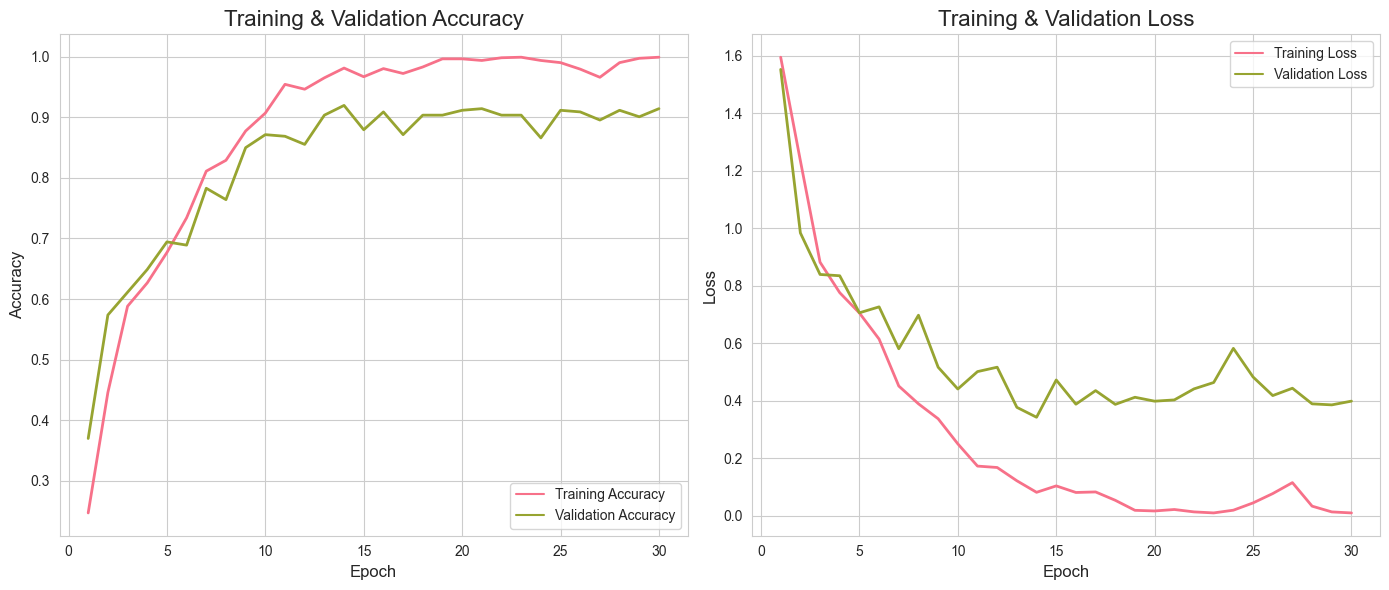

Final Training Accuracy: 0.9991047382354736
Final Validation Accuracy: 0.9142091274261475
Final Training Loss: 0.010594960302114487
Final Validation Loss: 0.39925041794776917


In [60]:
evaluate_model(history)

## Evaluating Test Dataset

In [61]:
def parse_test_data_from_file(filename):
    # lists to include texts from articles
    test_sentences = []

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skipping the header row

        for row in reader:
            # add the texts of a news article into the 'test_sentences' list
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            test_sentences.append(sentence)

    return test_sentences

In [62]:
test_sentences = parse_test_data_from_file("BBC News Test.csv")

print(f"Number of sentences in the test dataset: {len(test_sentences)}\n")
print(f"Number of words in the 1st sentence (after removing stopwords). {len(test_sentences[0].split())}\n")

Number of sentences in the test dataset: 735

Number of words in the 1st sentence (after removing stopwords). 98



In [63]:
test_tokenizer = fit_tokenizer(test_sentences, num_words, oov_token)

# get word_index
test_word_index = test_tokenizer.word_index

test_padded_seq = seq_and_pad(test_sentences, test_tokenizer, padding, max_len)

print(f"Number of words in the test vocabulary: {len(test_word_index)}\n")
print(f"Shape of padded training sequences: {test_padded_seq.shape}\n")

Number of words in the test vocabulary: 18207

Shape of padded training sequences: (735, 120)



In [64]:
predictions = model.predict(test_padded_seq)
# print(predictions)

# Get the class with the highest probability for each input sentence
predicted_classes = predictions.argmax(axis=1)
print(f'Predicted classes:\n\n {predicted_classes}')

23/23 [==============================] - 2s 27ms/step
Predicted classes:

 [3 2 2 3 1 0 3 4 2 2 3 4 1 1 3 4 3 2 4 4 4 4 2 3 3 1 0 3 2 2 4 3 2 3 2 2 1
 3 3 4 2 4 4 2 1 3 2 4 2 1 3 2 2 3 4 4 2 3 4 0 2 4 2 2 3 1 4 4 1 3 0 0 0 4
 0 2 0 4 0 2 3 2 3 2 3 3 1 1 2 3 3 3 4 4 0 2 1 4 1 0 3 2 2 4 2 2 4 1 4 2 0
 0 3 3 2 2 1 3 2 3 0 3 3 4 1 1 4 3 4 2 4 1 2 2 2 3 2 4 3 3 0 3 4 4 2 4 4 2
 3 3 2 4 3 1 2 2 2 3 4 3 2 4 1 1 2 1 3 3 3 4 2 3 3 1 4 2 4 2 4 4 3 2 1 4 3
 2 2 2 3 4 3 3 2 1 2 2 1 4 4 4 3 4 0 1 4 3 3 4 3 2 2 3 1 3 3 4 2 3 2 3 1 1
 2 4 4 1 1 2 3 2 3 2 4 2 1 4 2 3 2 2 2 2 0 2 3 0 2 3 3 2 3 2 4 2 3 2 3 0 2
 0 3 0 2 2 3 1 3 1 3 2 4 1 2 2 4 0 1 2 3 4 1 2 3 4 2 2 3 1 4 2 4 1 0 2 4 3
 4 3 2 1 2 2 2 0 3 3 1 3 2 4 4 1 4 3 2 1 3 4 3 2 2 2 2 2 4 2 0 3 3 2 2 1 2
 0 2 2 2 3 2 4 3 2 4 3 4 1 4 3 2 3 1 3 4 1 3 2 3 2 2 3 2 2 2 4 4 1 2 2 2 3
 4 4 1 2 4 0 2 3 0 3 3 2 3 3 0 2 0 3 4 3 4 2 4 3 2 1 1 4 2 3 3 3 4 3 3 2 3
 4 2 3 2 4 2 4 4 1 3 4 3 4 2 3 1 3 3 3 3 4 4 3 2 3 4 4 3 3 2 2 2 4 3 1 3 2
 2 2 4 3 3 4 2 4 2 3 2 2 

In [7]:
# values
TP = 80
FP = 10
FN = 5

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("F1 Score:", f1_score)


F1 Score: 0.9142857142857143


## Saving the Best Model

In [65]:
model.save("news_classifier_model.h5")

## Predicting Class of the Sentence

In [66]:
def predict_class(sentence, tokenizer, model, padding, maxlen):
    # Preprocess the sentence (remove stopwords)
    preprocessed_sentence = remove_stopwords(sentence)
    
    # Convert the preprocessed sentence to a token sequence
    token_sequence = tokenizer.texts_to_sequences([preprocessed_sentence])
    
    # Pad the token sequence
    padded_sequence = pad_sequences(token_sequence, padding=padding, maxlen=maxlen)
    
    # Make prediction using the model
    prediction = model.predict(padded_sequence)
    
    # Get the predicted class
    predicted_class = np.argmax(prediction)
    
    return predicted_class

# Example usage:
sentence_to_predict = "citizenship event for 18s touted citizenship ceremonies could be introduced for people celebrating their 18th birthday  charles clarke has said.  the idea will be tried as part of an overhaul of the way government approaches  inclusive citizenship  particularly for ethnic minorities. a pilot scheme based on ceremonies in australia will start in october. mr clarke said it would be a way of recognising young people reaching their voting age when they also gain greater independence from parents. britain s young black and asian people are to be encouraged to learn about the nation s heritage as part of the government s new race strategy which will also target specific issues within different ethnic minority groups. officials say the home secretary wants young people to feel they belong and to understand their  other cultural identities  alongside being british. the launch follows a row about the role of faith schools in britain. on monday school inspection chief david bell  accused some islamic schools of failing to teach pupils about their obligations to british society.  the muslim council of britain said ofsted boss mr bell s comments were  highly irresponsible . the home office started work on its community cohesion and race equality strategy last year and the outcome  launched on wednesday  is called  improving opportunity  strengthening society . it is aimed at tackling racism  exclusion  segregation and the rise in political and religious extremism.  it represents a move away from the one-size-fits-all approach to focus on specifics within cultural groups   said a home office spokesman.  it is not right to say that if you are from a black or ethnic minority group you must be disadvantaged.  the spokesman highlighted specific issues that affect particular communities - for example people of south asian origin tend to suffer from a high incidence of heart disease.   it is about drilling down and focusing on these sorts of problems   the spokesman added. launching the initiative mr clarke said enormous progress had been made on race issues in recent years. he added:  but while many members of black and minority ethnic communities are thriving  some may still find it harder to succeed in employment or gain access to healthcare  education or housing.  this strategy sets out the government s commitment to doing more to identify and respond to the specific needs of minorities in our society.  some 8% of the uk population described themselves as coming from a non-white ethnic minority in the 2001 census.  the downing street strategy unit in 2003 said people from indian and chinese backgrounds were doing well on average  often outperforming white people in education and earnings. but those of pakistani  bangladeshi and black caribbean origin were significantly more likely to be unemployed and earn less than whites  it said. the home office wants more initiatives which try to promote a sense of belonging by encouraging young people to take part in voluntary work. the programmes are designed to support the citizenship lessons already taking place in schools."
predicted_class = predict_class(sentence_to_predict, tokenizer, model, padding, max_len)
print(f"The predicted class for the sentence is: {predicted_class}")


1/1 [==============================] - 0s 47ms/step
The predicted class for the sentence is: 2
